# CZ4042 Neural Networks & Deep Learning
## Assignment - 1: Part A, Question 4

> Gupta Jay  
> U1822549K  
> School of Computer Science and Engineering  
> Nanyang Technological University, Singapore  

## Imports

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import pandas as pd
import numpy as np
import time

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [3]:
print(tf.__version__)

2.6.0


In [4]:
# Supress any warnings for clean presentation
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

Split and scale dataset

In [7]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [8]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


## Part A: 3-layer Neural Network

In [9]:
def getModel(neuron_size, first_layer_activation, second_layer_activation, add_additional_layer):
    # Inputs -> Dense -> Dropout -> Dense -> Dropout -> Dense (Output)
    model = keras.Sequential()
    model.add(layers.Dense(neuron_size, activation=first_layer_activation, input_dim=X_train.shape[1]))
    model.add(layers.Dropout(0.3))
    if(add_additional_layer):
        model.add(layers.Dense(neuron_size, activation=first_layer_activation))
        model.add(layers.Dropout(0.3))
    model.add(layers.Dense(df['label'].nunique(), activation=second_layer_activation))
    return model

def getOptimizer():
    # Adam Optimizer (Default Parameters) -> Stochastic Gradient Descent
    optimizer = keras.optimizers.Adam()
    return optimizer

In [10]:
# Hyperparameters
neuron_size = 32
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = getOptimizer()

model = getModel(neuron_size, "relu", "softmax", add_additional_layer=True)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

2021-10-13 23:30:54.437008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


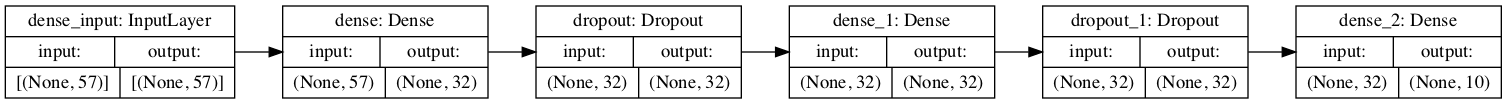

In [11]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [12]:
epochs = 50
verbose = 1
batch_size = 1

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)

2021-10-13 23:30:55.230052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
700/700 [==============================] - 1s 1ms/step - loss: 2.1039 - accuracy: 0.2443 - val_loss: 1.6637 - val_accuracy: 0.4833
Epoch 2/50
700/700 [==============================] - 1s 864us/step - loss: 1.7225 - accuracy: 0.3843 - val_loss: 1.4201 - val_accuracy: 0.5100
Epoch 3/50
700/700 [==============================] - 1s 776us/step - loss: 1.4900 - accuracy: 0.4671 - val_loss: 1.2270 - val_accuracy: 0.5867
Epoch 4/50
700/700 [==============================] - 1s 717us/step - loss: 1.2973 - accuracy: 0.5214 - val_loss: 1.1334 - val_accuracy: 0.6100
Epoch 5/50
700/700 [==============================] - 1s 722us/step - loss: 1.2659 - accuracy: 0.5514 - val_loss: 1.1446 - val_accuracy: 0.5733
Epoch 6/50
700/700 [==============================] - 1s 730us/step - loss: 1.1543 - accuracy: 0.5771 - val_loss: 1.0795 - val_accuracy: 0.6033
Epoch 7/50
700/700 [==============================] - 1s 795us/step - loss: 1.1096 - accuracy: 0.6271 - val_loss: 1.0299 - val_accuracy: 0

### Mean Cross-Validation Accuracies

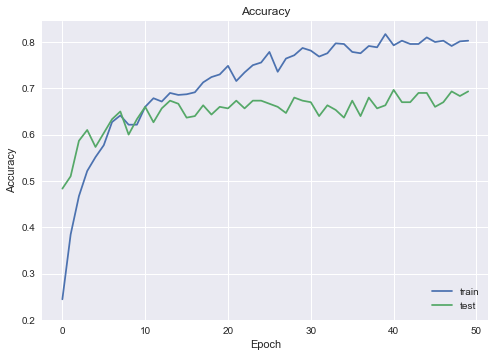

In [13]:
plt.style.use("seaborn")

# Extracting Train & Test Accuracy from model history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting
plt.plot(accuracy)
plt.plot(val_accuracy)

# Labelling
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.yticks(np.arange(0.2, 0.9, 0.1))

plt.show()

## Part B: Optimal 2-layer Neural Network vs. 3-layer Neural Network

In [14]:
epochs = 50
verbose = 1

# Parameters for Optimal 2-layer network
batch_size = 4
neuron_size = 32

loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
optimizer = getOptimizer()

model_2_layer = getModel(neuron_size, "relu", "softmax", add_additional_layer=False)
model_2_layer.compile(loss=loss, optimizer=optimizer, metrics=metrics)
history_2_layer = model_2_layer.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose, batch_size=batch_size)

Epoch 1/50
175/175 [==============================] - 1s 1ms/step - loss: 2.1061 - accuracy: 0.2557 - val_loss: 1.7140 - val_accuracy: 0.3767
Epoch 2/50
175/175 [==============================] - 0s 830us/step - loss: 1.6175 - accuracy: 0.4257 - val_loss: 1.4891 - val_accuracy: 0.4500
Epoch 3/50
175/175 [==============================] - 0s 951us/step - loss: 1.4048 - accuracy: 0.4986 - val_loss: 1.3589 - val_accuracy: 0.5000
Epoch 4/50
175/175 [==============================] - 0s 895us/step - loss: 1.3075 - accuracy: 0.5243 - val_loss: 1.2786 - val_accuracy: 0.5167
Epoch 5/50
175/175 [==============================] - 0s 817us/step - loss: 1.2222 - accuracy: 0.5429 - val_loss: 1.2184 - val_accuracy: 0.5667
Epoch 6/50
175/175 [==============================] - 0s 774us/step - loss: 1.1022 - accuracy: 0.6157 - val_loss: 1.1747 - val_accuracy: 0.5867
Epoch 7/50
175/175 [==============================] - 0s 811us/step - loss: 1.0780 - accuracy: 0.6300 - val_loss: 1.1339 - val_accuracy: 0

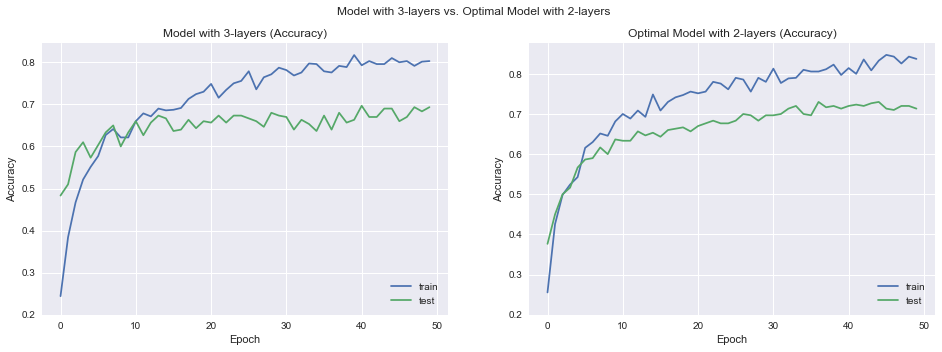

In [15]:
plt.style.use("seaborn")

# Plot Configuration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Model with 3-layers vs. Optimal Model with 2-layers')

# Plot for model with 3 layers
# ------
# Extracting Train & Test Accuracy from model history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting
ax1.plot(accuracy)
ax1.plot(val_accuracy)

# Labelling
ax1.set_title('Model with 3-layers (Accuracy)')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'test'], loc='lower right')
ax1.set_yticks(np.arange(0.2, 0.9, 0.1))
# ------

# Plot for model with 2 layers (optimal)
# ------
# Extracting Train & Test Accuracy from model history
accuracy = history_2_layer.history['accuracy']
val_accuracy = history_2_layer.history['val_accuracy']

# Plotting
ax2.plot(accuracy)
ax2.plot(val_accuracy)

# Labelling
ax2.set_title('Optimal Model with 2-layers (Accuracy)')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'test'], loc='lower right')
ax2.set_yticks(np.arange(0.2, 0.9, 0.1))
# ------

plt.show()

From the two graphs plotted above, we observe that there is not much difference in accuracies between the model with 3-layers (left) and the optimal model with 2-layers (right). The test accuracies are close to `70%` and the train accuracies are close to `90%` for both the models at the end of 50 epochs. 

In such a case, we should prefer the optimal model with 2-layers (right) since it is simpler, and will be able to generalize better than the more complex 3-layer model.

## End of Part A, Question 4. 